In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,854 cases (7 day average) as of Fri 21 May, +48.9 since Thu 20 May
85 hospitalised (7 day average) as of Sun 23 May, +0.0 since Sun 23 May
5 died (7 day average) as of Fri 21 May, +0.7 since Thu 20 May


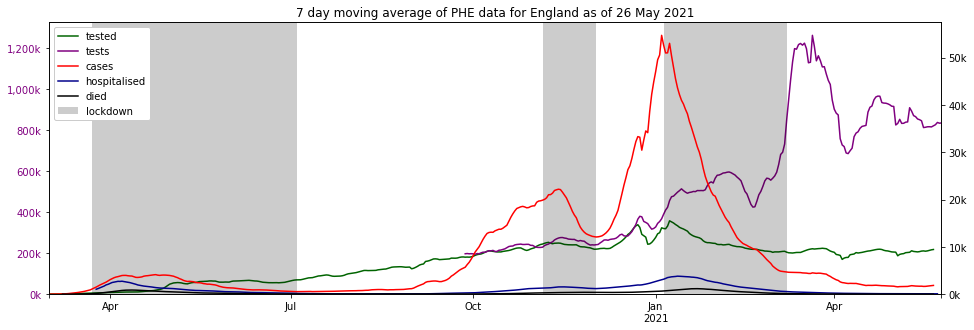

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

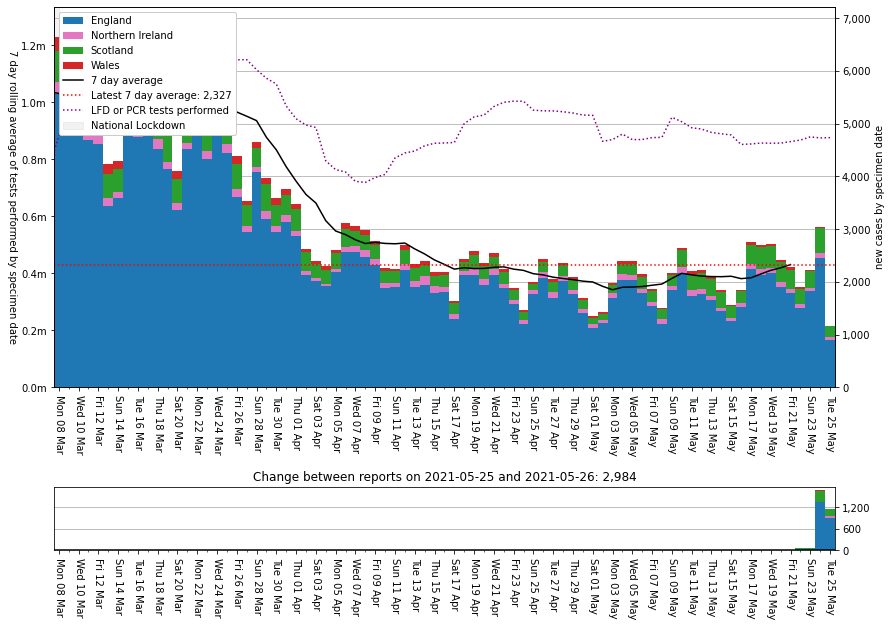

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

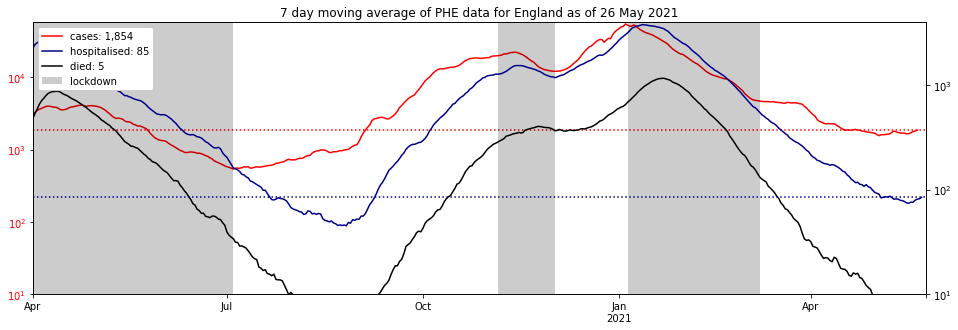

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

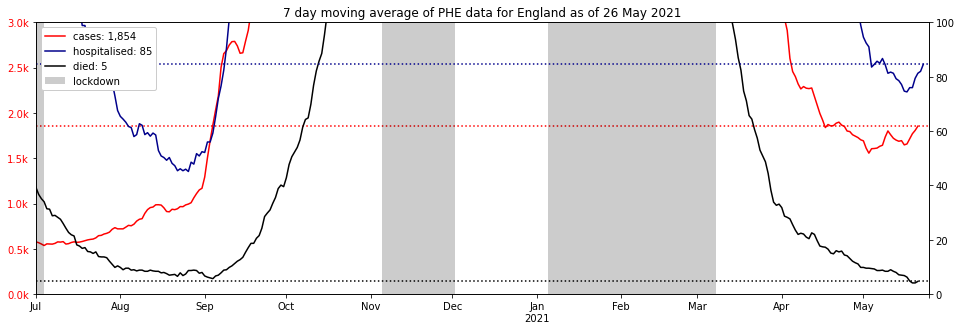

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,25 May 21,"+20,034,770","+32,079,373","+20,034,770","+327,467","+157,084","+327,467"
Northern Ireland,25 May 21,"+630,170","+1,030,811","+630,170","+9,406","+4,368","+9,406"
Scotland,25 May 21,"+1,913,809","+3,155,733","+1,913,809","+32,595","+17,367","+32,595"
Wales,25 May 21,"+1,037,749","+2,112,647","+1,037,749","+18,519","+7,328","+18,519"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,20034770.0,32079373.0,12044603.0,56286961,35.593981,21.398567,43.007452
1,Northern Ireland,N92000002,630170.0,1030811.0,400641.0,1893667,33.277762,21.156888,45.565350
2,Scotland,S92000003,1913809.0,3155733.0,1241924.0,5463300,35.030275,22.732122,42.237604
3,Wales,W92000004,1037749.0,2112647.0,1074898.0,3152879,32.914330,34.092586,32.993083


'partial: 38,378,564 (57.5%), full: 23,616,498'

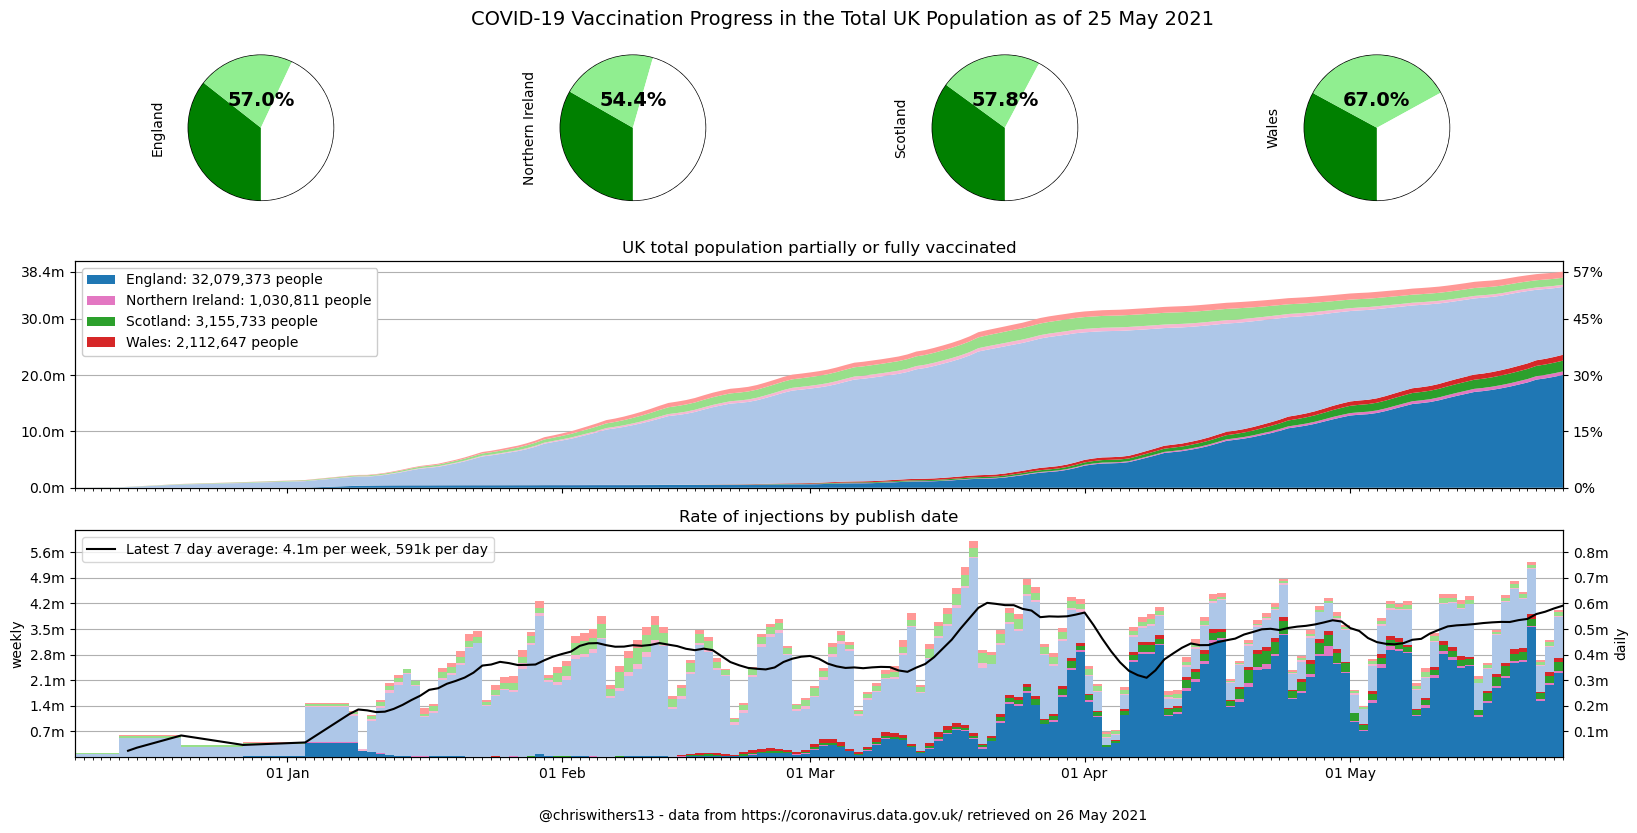

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

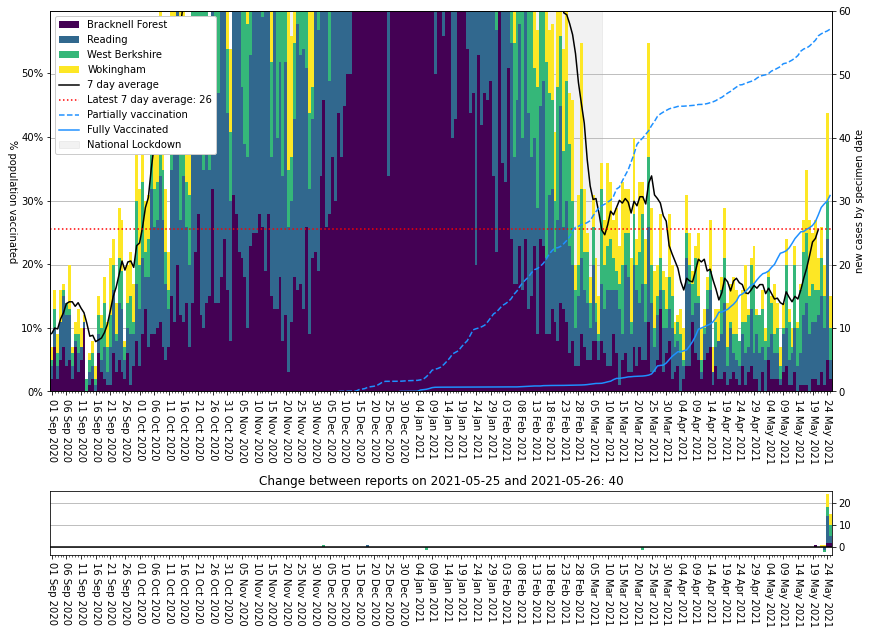

In [9]:
plot_areas(for_date, areas=my_areas, earliest='2020-09', ylim=60,  lines=population_vaccinated)

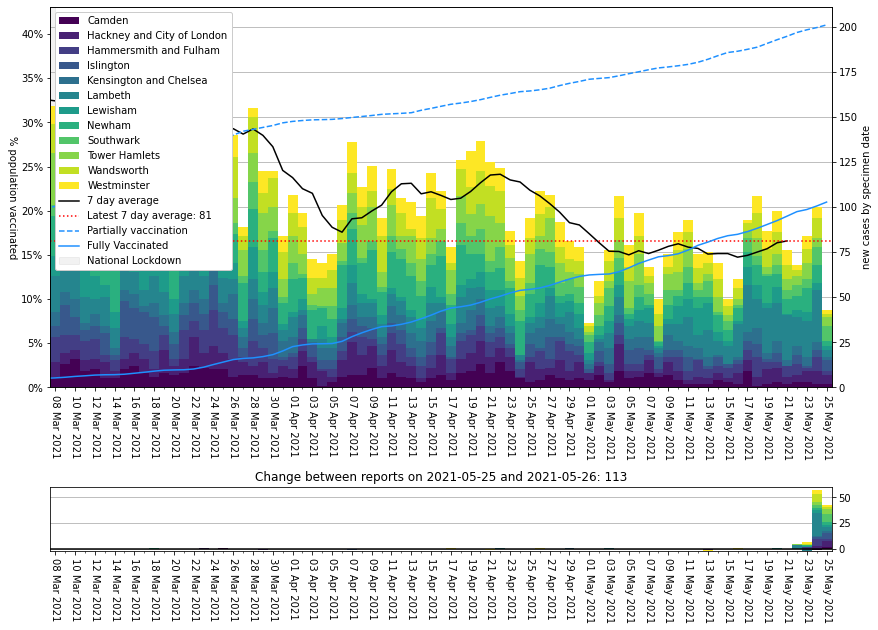

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,317.309748,475.0,2021-05-25
E08000001,Bolton,295.948531,851.0,2021-05-25
E07000125,Rossendale,202.848269,145.0,2021-05-25
E06000055,Bedford,170.232902,295.0,2021-05-25
S12000049,Glasgow City,121.619914,770.0,2021-05-25
S12000005,Clackmannanshire,120.294917,62.0,2021-05-25
S12000038,Renfrewshire,109.994417,197.0,2021-05-25
S12000011,East Renfrewshire,99.445200,95.0,2021-05-25
E07000120,Hyndburn,98.713029,80.0,2021-05-25


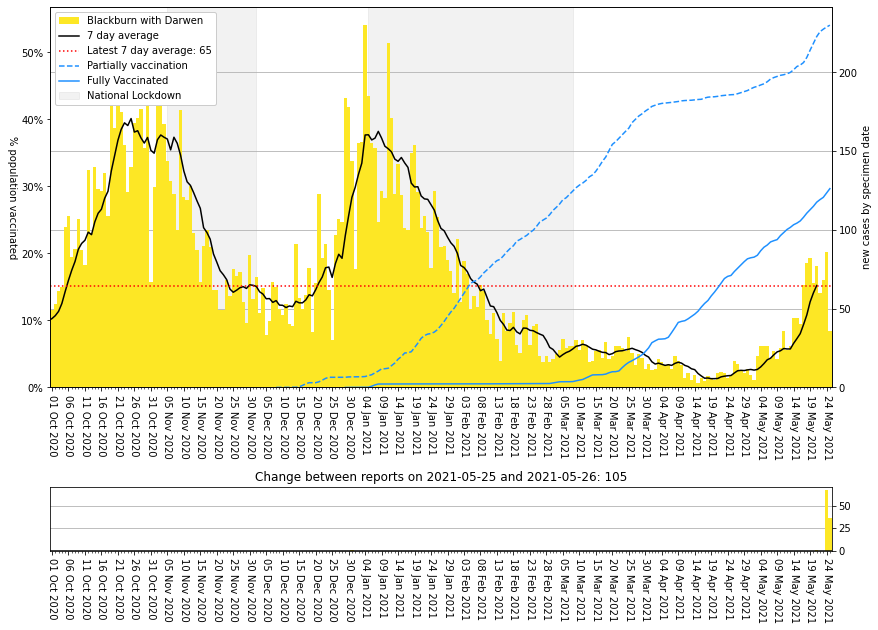

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,295.948531,851.0,2021-05-25
S12000049,Glasgow City,121.619914,770.0,2021-05-25
E06000008,Blackburn with Darwen,317.309748,475.0,2021-05-25
E08000034,Kirklees,96.865073,426.0,2021-05-25
E08000003,Manchester,63.307395,350.0,2021-05-25
E08000025,Birmingham,25.836037,295.0,2021-05-25
E06000055,Bedford,170.232902,295.0,2021-05-25
E08000032,Bradford,53.725990,290.0,2021-05-25
E08000035,Leeds,32.150733,255.0,2021-05-25


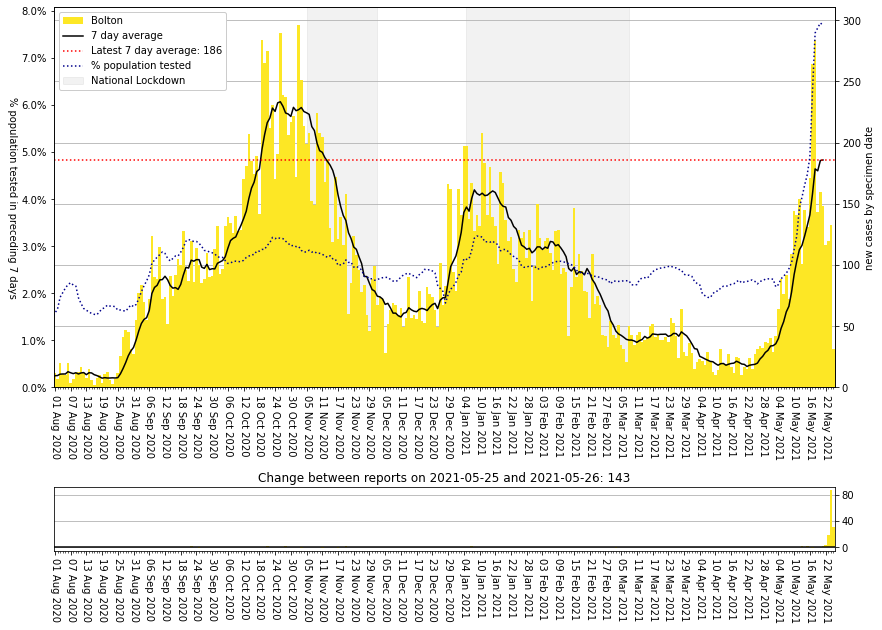

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested, earliest='2020-08')

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

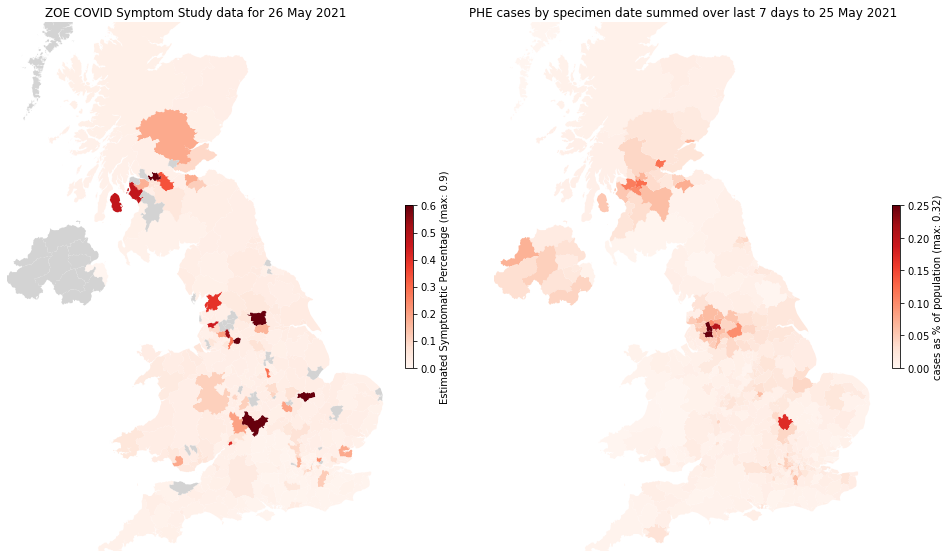

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...